## Supply chain disruption mitigation using langgraph

### Import statements


In [571]:
from typing_extensions import TypedDict, List, Dict, Any
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import os, random, copy, json
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, ToolMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, END

load_dotenv()

True

### Demo supply chain data


In [572]:
initial_mock_supply_chain_data = {
    "raw_materials": {
        "steel": {"quantity": 1000, "supplier": "SupplierA", "status": "available"},
        "plastic": {"quantity": 500, "supplier": "SupplierB", "status": "available"},
    },
    "production_lines": {
        "line1": {
            "status": "operational",
            "output_rate": 100,
            "maintenance_needed": False,
        },
        "line2": {
            "status": "operational",
            "output_rate": 80,
            "maintenance_needed": False,
        },
    },
    "transportation_routes": {
        "route_east": {"status": "open", "delay_hours": 0, "capacity_used_percent": 30},
        "route_west": {"status": "open", "delay_hours": 0, "capacity_used_percent": 20},
    },
    "inventory": {
        "finished_goods_warehouse_A": 200,
        "finished_goods_warehouse_B": 150,
    },
    "orders": {
        "pending_orders_count": 50,
        "critical_orders_count": 5,
    },
}

### Defining state


In [573]:
class AgentState(TypedDict):
    supply_chain_data: Dict[str, Any]
    disruption_detected: bool
    disruption_details: str
    mitigation_options: List[Dict[str, str]]
    selected_option: Dict[str, str]
    user_feedback: str
    user_feedback_text: str
    run_count: int
    messages: List[Dict[str, str]]
    next_agent: str

### Initializing LLM


In [574]:
general_llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.5,
    google_api_key=os.getenv("GEMINI_API_KEY"),
)

tool_calling_llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash", temperature=0, google_api_key=os.getenv("GEMINI_API_KEY")
)

supervisor_llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash", temperature=0, google_api_key=os.getenv("GEMINI_API_KEY")
)

### Defining tools


In [575]:
@tool
def get_supply_chain_data() -> Dict[str, Any]:
    """
    This function is used to get the current simulated supply_chain_data.
    It returns a snapshot of the supply chain's state.
    """
    print("Tool: get_supply_chain_data called.")
    return initial_mock_supply_chain_data

In [576]:
tool_calling_llm_with_tools = tool_calling_llm.bind_tools([get_supply_chain_data])

### Defining agents


In [577]:
def monitoring_and_detection_agent(state: AgentState):
    """
    Use the get_supply_chain_data tool to get the current state of the supply chain. And detects/describes the disruption.
    """
    messages = state.get("messages", [])
    messages.append(HumanMessage(content="Get the current state of the supply chain?"))
    llm_response = tool_calling_llm_with_tools.invoke(messages)
    messages.append(AIMessage(content=llm_response.content))

    current_data = {}
    tool_calls = llm_response.tool_calls

    if tool_calls:
        for tool_call in tool_calls:
            if isinstance(tool_call, dict):
                tool_name = tool_call.get("name")
                tool_args = tool_call.get("args", {})
                tool_id = tool_call.get("id")
            else:
                tool_name = tool_call.name
                tool_args = tool_call.args
                tool_id = tool_call.id

            print(
                f"DEBUG: Processing tool call - Name: {tool_name}, Args: {tool_args}, ID: {tool_id}"
            )

            if tool_name == "get_supply_chain_data":
                tool_output = get_supply_chain_data({})
                current_data = tool_output
                messages.append(
                    ToolMessage(
                        content=json.dumps(tool_output),
                        tool_call_id=tool_id if tool_id else "generated_id",
                    )
                )
                print(
                    "MonitoringAndDetection: Successfully retrieved supply chain data via LLM tool call."
                )
                break
            else:
                print(
                    f"MonitoringAndDetection: LLM suggested an unexpected tool: {tool_name}. Using initial mock data as fallback."
                )
                current_data = initial_mock_supply_chain_data
                messages.append(
                    SystemMessage(
                        content=f"Fallback: Used initial mock data as LLM suggested unexpected tool: {tool_name}."
                    )
                )
                break
    else:
        print(
            "MonitoringAndDetection: LLM did not suggest any tool calls. Using initial mock data as fallback."
        )
        current_data = initial_mock_supply_chain_data
        messages.append(
            SystemMessage(
                content="Fallback: Used initial mock data as LLM did not suggest tool call."
            )
        )

    # Create a deep copy to allow modifications for simulation
    current_data = copy.deepcopy(current_data)

    # Step 2: Introduce Simulated Disruptions
    run_count = state.get("run_count", 0)

    if run_count == 0:
        print(
            "MonitoringAndDetection: FORCING Production Line 1 DOWN for initial test!"
        )
        current_data["production_lines"]["line1"]["status"] = "down"
        current_data["production_lines"]["line1"]["output_rate"] = 0
        current_data["production_lines"]["line1"]["maintenance_needed"] = True
    elif run_count == 1:
        print(
            "MonitoringAndDetection: FORCING East transportation route BLOCKED on second run!"
        )
        current_data["transportation_routes"]["route_east"]["status"] = "blocked"
        current_data["transportation_routes"]["route_east"]["delay_hours"] = 24
        current_data["transportation_routes"]["route_east"][
            "capacity_used_percent"
        ] = 100
    else:
        # Random disruptions for subsequent runs
        if random.random() < 0.2:
            line_to_disrupt = random.choice(
                list(current_data["production_lines"].keys())
            )
            if (
                current_data["production_lines"][line_to_disrupt]["status"]
                == "operational"
            ):
                print(
                    f"MonitoringAndDetection: SIMULATING Production Line {line_to_disrupt} DOWN!"
                )
                current_data["production_lines"][line_to_disrupt]["status"] = "down"
                current_data["production_lines"][line_to_disrupt]["output_rate"] = 0
                current_data["production_lines"][line_to_disrupt][
                    "maintenance_needed"
                ] = True

    # Simulate general operational changes
    current_data["inventory"]["finished_goods_warehouse_A"] = max(
        0,
        current_data["inventory"]["finished_goods_warehouse_A"] - random.randint(1, 5),
    )
    current_data["orders"]["pending_orders_count"] += random.randint(0, 2)

    print(
        f"MonitoringAndDetection Output - Line 1 Status: {current_data['production_lines']['line1']['status']}"
    )
    print(
        f"MonitoringAndDetection Output - East Route Status: {current_data['transportation_routes']['route_east']['status']}"
    )

    data_summary = f"""
    Current Supply Chain Data after monitoring:
    - Raw Materials: {current_data['raw_materials']}
    - Production Lines: {current_data['production_lines']}
    - Transportation Routes: {current_data['transportation_routes']}
    - Inventory: {current_data['inventory']}
    - Orders: {current_data['orders']}
    """

    detection_prompt = f"""
    Analyze the following supply chain data for any significant disruptions or anomalies.
    {data_summary}

    If a disruption is detected, describe it clearly and concisely, including:
    1. What part of the supply chain is affected (e.g., Production, Transportation, Raw Materials).
    2. The specific issue (e.g., "Line 1 is down", "East route blocked", "Steel supplier delayed").
    3. Its immediate impact (e.g., "zero output", "24-hour delay", "50% quantity reduction").

    If no disruption is detected, state "No disruption detected."
    Your response should start with "Disruption Detected:" followed by details, or "No disruption detected."
    """
    messages.append(HumanMessage(content=detection_prompt))
    llm_response_detection = general_llm.invoke(messages)
    messages.append(llm_response_detection)

    disruption_text = llm_response_detection.content
    disruption_detected = False
    disruption_details = ""

    if "Disruption Detected:" in disruption_text:
        disruption_detected = True
        disruption_details = disruption_text.replace("Disruption Detected:", "").strip()
        next_agent = "mitigation_agent"
        print(f"MonitoringAndDetection: DISRUPTION DETECTED: {disruption_details}")
    else:
        print("MonitoringAndDetection: No disruption detected.")
        next_agent = "END_PROCESS"

    return {
        "supply_chain_data": current_data,
        "run_count": run_count + 1,
        "disruption_detected": disruption_detected,
        "disruption_details": disruption_details,
        "messages": messages,
        "mitigation_options": [],  # Clear previous options
        "selected_option": {},  # Clear previous selection
        "user_feedback": "",  # Clear previous feedback
        "user_feedback_text": "",  # Clear previous feedback text
        "next_agent": next_agent,
    }

In [578]:
def mitigation_agent(state: AgentState) -> Dict[str, Any]:
    """
    MitigationAgent: Generates mitigation options and their simulated consequences using LLM.
    Handles re-evaluation based on user feedback.
    """

    print("\n--- MitigationAgent: Generating Options and Consequences ---")
    disruption_details = state["disruption_details"]
    current_data = state["supply_chain_data"]
    user_feedback_text = state.get("user_feedback_text", "")
    messages = state.get("messages", [])

    data_summary = f"""
    Current Supply Chain Data:
    - Raw Materials: {current_data['raw_materials']}
    - Production Lines: {current_data['production_lines']}
    - Transportation Routes: {current_data['transportation_routes']}
    - Inventory: {current_data['inventory']}
    - Orders: {current_data['orders']}
    """

    prompt_prefix = ""
    if user_feedback_text:
        prompt_prefix = f"The user previously provided feedback: '{user_feedback_text}'. Please revise your strategies based on this feedback.\n"
        print(f"MitigationAgent: Incorporating user feedback: {user_feedback_text}")

    prompt = f"""
    {prompt_prefix}
    A supply chain disruption has occurred: "{disruption_details}".
    Given the current state of the supply chain:
    {data_summary}

    Brainstorm 3-5 distinct and actionable mitigation strategies.
    For EACH strategy, also provide a plausible short-term simulated consequence (what would happen if this strategy is implemented).
    The consequence should describe the impact on production, inventory, delivery times, or costs.

    Format your response as a JSON array of objects, where each object has 'strategy' and 'consequence' keys.
    Example:
    ```json
    [
      {{
        "strategy": "Find alternative supplier for steel.",
        "consequence": "Steel quantity will recover in 3 days, but at 10% higher cost."
      }},
      {{
        "strategy": "Shift production to Line 2.",
        "consequence": "Overall production rate will drop by 20% for 5 days, but avoid complete halt."
      }}
    ]
    ```
    """
    messages.append(HumanMessage(content=prompt))
    llm_response = general_llm.invoke(messages)
    print("mitigation_agent", llm_response)
    messages.append(llm_response)

    mitigation_options_raw = llm_response.content
    mitigation_options = []
    try:
        # Attempt to parse the JSON output from LLM
        mitigation_options = json.loads(mitigation_options_raw)
        # Basic validation to ensure it's a list of dicts with expected keys
        if not isinstance(mitigation_options, list) or not all(
            isinstance(item, dict) and "strategy" in item and "consequence" in item
            for item in mitigation_options
        ):
            raise ValueError("LLM response not in expected JSON format.")
    except json.JSONDecodeError:
        print(
            "MitigationAgent: Warning: LLM did not return valid JSON. Attempting fallback parsing."
        )
        # Fallback parsing if LLM doesn't return perfect JSON
        # This is a simple fallback and might not always be robust
        lines = mitigation_options_raw.split("\n")
        current_strategy = None
        current_consequence = None
        for line in lines:
            line = line.strip()
            if line.startswith('"strategy":'):
                if current_strategy and current_consequence:
                    mitigation_options.append(
                        {
                            "strategy": current_strategy,
                            "consequence": current_consequence,
                        }
                    )
                current_strategy = line.replace('"strategy":', "").strip().strip('",')
                current_consequence = None  # Reset consequence
            elif line.startswith('"consequence":'):
                current_consequence = (
                    line.replace('"consequence":', "").strip().strip('",')
                )
        if current_strategy and current_consequence:
            mitigation_options.append(
                {"strategy": current_strategy, "consequence": current_consequence}
            )

    print(f"MitigationAgent: Generated Options:\n{mitigation_options}")

    return {
        "mitigation_options": mitigation_options,
        "messages": messages,
        "user_feedback": "",  # Clear feedback after processing
        "user_feedback_text": "",  # Clear feedback text
        "next_agent": "human_interaction_agent",
    }

In [579]:
def human_interaction_agent(state: AgentState) -> Dict[str, Any]:
    """
    HumanInteractionAgent: Presents options to the user and collects their choice/feedback.
    """
    print("\n--- HumanInteractionAgent: Awaiting User Input ---")
    print("state", state)
    mitigation_options = state.get("mitigation_options")
    print("mitigation_options", mitigation_options)
    messages = state.get("messages", [])

    print("\n--- Proposed Mitigation Strategies ---")
    for i, option in enumerate(mitigation_options):
        print(f"Option {i+1}:")
        print(f"  Strategy: {option['strategy']}")
        print(f"  Consequence: {option['consequence']}")
        print("-" * 30)

    print("\nWhat would you like to do?")
    print("1. Select an option (type its number, e.g., '1', '2').")
    print(
        "2. Re-evaluate (type 're-evaluate' followed by feedback, e.g., 're-evaluate too expensive')."
    )

    user_input_raw = input("Your choice: ").strip()
    user_feedback = ""
    user_feedback_text = ""
    selected_option = {}

    if user_input_raw.lower().startswith("re-evaluate"):
        user_feedback = "re-evaluate"
        user_feedback_text = user_input_raw[len("re-evaluate") :].strip()
        next_agent = "mitigation_agent"
        print(
            f"HumanInteraction: User requested re-evaluation with feedback: '{user_feedback_text}'"
        )
    else:
        try:
            choice_index = int(user_input_raw) - 1
            if 0 <= choice_index < len(mitigation_options):
                print(mitigation_options)
                selected_option = mitigation_options[choice_index]
                user_feedback = "accept"
                next_agent = "execution_and_reporting_agent"
                print(
                    f"HumanInteraction: User selected Option {choice_index+1}: {selected_option['strategy']}"
                )
            else:
                next_agent = "END_PROCESS"
                print("HumanInteraction: Invalid option number. Please try again.")
                user_feedback = (
                    "invalid_choice"  # Signal to supervisor to re-loop this agent
                )
        except ValueError:
            next_agent = "END_PROCESS"
            print(
                "HumanInteraction: Invalid input. Please type a number or 're-evaluate'."
            )
            user_feedback = (
                "invalid_choice"  # Signal to supervisor to re-loop this agent
            )

    messages.append(AIMessage(content=f"User input received: {user_input_raw}"))

    return {
        "selected_option": selected_option,
        "user_feedback": user_feedback,
        "user_feedback_text": user_feedback_text,
        "messages": messages,
        "next_agent": next_agent,
    }

In [580]:
def execution_and_reporting_agent(state: AgentState) -> Dict[str, Any]:
    """
    ExecutionAndReportingAgent: Generates a final report based on the chosen strategy.
    """
    print("\n--- ExecutionAndReportingAgent: Finalizing and Reporting ---")
    disruption_details = state.get("disruption_details")
    selected_option = state.get("selected_option")
    messages = state.get("messages", [])

    if not selected_option:
        print("ExecutionAndReporting: No option was selected. Cannot generate report.")
        return {"messages": messages, "next_agent": "END_PROCESS"}

    final_report_prompt = f"""
    A supply chain disruption was identified: "{disruption_details}".
    The chosen mitigation strategy is: "{selected_option.get('strategy', 'N/A')}".
    Its simulated consequence is: "{selected_option.get('consequence', 'N/A')}".

    Generate a concise final report for a supply chain manager, confirming the chosen action
    and its expected immediate impact. Conclude with a statement about monitoring the situation.
    """
    messages.append(HumanMessage(content=final_report_prompt))
    llm_response = general_llm.invoke(messages)
    messages.append(llm_response)

    final_report = llm_response.content
    print("\n--- FINAL SUPPLY CHAIN DISRUPTION REPORT ---")
    print(final_report)
    print("------------------------------------------")

    return {
        "messages": messages,
        "next_agent": "END_PROCESS",
        # No further state updates needed, as this is typically the end of the cycle
    }

In [581]:
def supervisor_agent(state: AgentState) -> str:
    """
    Supervisor Agent: Orchestrates the workflow by deciding which sub-agent to call next.
    Uses an LLM for routing decisions.
    """

    disruption_details_summary = (state.get("disruption_details") or "")[:100] + (
        "..." if len(state.get("disruption_details") or "") > 100 else ""
    )
    mitigation_options_count = len(
        state.get("mitigation_options", [])
    )  # <--- Safely get length
    selected_option_strategy = (
        state.get("selected_option", {}).get("strategy") or "None"
    )[:50] + (
        "..."
        if len(state.get("selected_option", {}).get("strategy") or "") > 50
        else ""
    )
    user_feedback_text_summary = (state.get("user_feedback_text") or "")[:50] + (
        "..." if len(state.get("user_feedback_text") or "") > 50 else ""
    )
    print("\n--- Supervisor Agent: Deciding Next Step ---")
    current_state_summary = f"""
    Current Supply Chain Agent State:
    - Disruption Detected: {state.get('disruption_detected')}
    - Disruption Details: {disruption_details_summary}...
    - Mitigation Options Count: {mitigation_options_count}
    - Selected Option: {selected_option_strategy}...
    - User Feedback: {user_feedback_text_summary}...
    - Run Count: {state.get('run_count')}
    - Next Agent: {state.get('next_agent')}
    """

    # Define the available sub-agents for the supervisor to choose from
    available_agents = [
        "monitoring_and_detection_agent",
        "mitigation_agent",
        "human_interaction_agent",
        "execution_and_reporting_agent",
    ]

    next_step_prompt = f"""
    The current state of the App is as follows:
    {current_state_summary}

    Based on this state, determine the most appropriate next step for the agent.
    Choose one of the following actions:
    {', '.join(available_agents)}, or 'END_PROCESS'.

    Look for the next agent in the {current_state_summary} to determine the what the next agent should be.

    Your response should be ONLY the name of the chosen action (e.g., 'monitoring_and_detection_agent', 'END_PROCESS').
    """

    supervisor_messages = [
        SystemMessage(
            content="You are a Supply Chain Agent Supervisor. Your role is to direct the workflow by selecting the next sub-agent based on the current state. Be precise in your choice."
        ),
        HumanMessage(content=next_step_prompt),
    ]

    llm_response = supervisor_llm.invoke(supervisor_messages)
    next_agent_name = llm_response.content.strip()

    # Basic validation for LLM output, fallback to monitoring if invalid
    if next_agent_name not in available_agents and next_agent_name != "END_PROCESS":
        print(
            f"Supervisor: Warning: LLM returned an invalid agent name '{next_agent_name}'. Defaulting to 'monitoring_and_detection_agent'."
        )
        next_agent_name = "monitoring_and_detection_agent"

    print(f"Supervisor: Decided next agent: {next_agent_name}")
    return {"next_agent": next_agent_name}

### Defining workflow

In [582]:
workflow = StateGraph(AgentState)

workflow.add_node("monitoring_and_detection_agent", monitoring_and_detection_agent)
workflow.add_node("mitigation_agent", mitigation_agent)
workflow.add_node("human_interaction_agent", human_interaction_agent)
workflow.add_node("execution_and_reporting_agent", execution_and_reporting_agent)
workflow.add_node("supervisor_agent", supervisor_agent)

workflow.set_entry_point("supervisor_agent")

workflow.add_conditional_edges(
    "supervisor_agent",  # From the supervisor node
    lambda state: state[
        "next_agent"
    ],  # Use the supervisor_agent function to determine the next node
    {
        "monitoring_and_detection_agent": "monitoring_and_detection_agent",
        "mitigation_agent": "mitigation_agent",
        "human_interaction_agent": "human_interaction_agent",
        "execution_and_reporting_agent": "execution_and_reporting_agent",
        "END_PROCESS": END,  # Special keyword to end the graph
    },
)

workflow.add_edge("monitoring_and_detection_agent", "supervisor_agent")
workflow.add_edge("mitigation_agent", "supervisor_agent")
workflow.add_edge("human_interaction_agent", "supervisor_agent")
workflow.add_edge("execution_and_reporting_agent", "supervisor_agent")

app = workflow.compile()

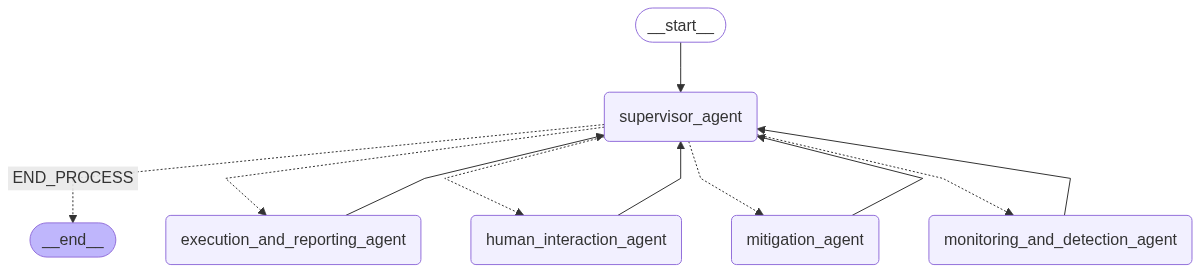

In [583]:
app

### Running the workflow

In [584]:
initial_state_for_run = {
    "supply_chain_data": {},  # Will be populated by monitoring_and_detection_agent
    "disruption_detected": False,
    "disruption_details": "",
    "mitigation_options": [],
    "selected_option": {},
    "user_feedback": "",
    "user_feedback_text": "",
    "run_count": 0,
    "messages": [],  # Initialize messages list for LLM conversation history
    "next_agent": "monitoring_and_detection_agent",
}

In [585]:
try:
    for s in app.stream(initial_state_for_run):
        # Print the current state after each node's execution
        print("\n--- Current State After Node Execution ---")
        for key, value in s.items():
            if key == "__end__":
                print(f"Graph Ended: {value}")
            elif key == "messages":
                # Optionally print a summary of messages to avoid clutter
                # print(f"Messages count: {len(value)}")
                print(f"Messages: {value}")  # Uncomment for full message history
            elif key == "supply_chain_data":
                # Print a summary of supply_chain_data
                print(
                    f"Supply Chain Data (summary): Production Line 1 Status: {value.get('production_lines', {}).get('line1', {}).get('status')}, East Route Status: {value.get('transportation_routes', {}).get('route_east', {}).get('status')}"
                )
            elif key == "mitigation_options":
                print(f"Mitigation Options Count: {len(value)}")
                # print(f"Mitigation Options: {json.dumps(value, indent=2)}") # Uncomment for full options
            elif key == "selected_option":
                print(f"Selected Option: {value.get('strategy', 'None')}")
            else:
                print(f"{key}: {value}")
        print("------------------------------------------")

except Exception as e:
    print(f"\nAn error occurred during graph execution: {e}")

print("\nMulti-Agent System Finished.")


--- Supervisor Agent: Deciding Next Step ---
Supervisor: Decided next agent: monitoring_and_detection_agent

--- Current State After Node Execution ---
supervisor_agent: {'next_agent': 'monitoring_and_detection_agent'}
------------------------------------------
DEBUG: Processing tool call - Name: get_supply_chain_data, Args: {}, ID: c05f0ea2-8300-4d2f-8cbb-e45864fd1402
Tool: get_supply_chain_data called.
MonitoringAndDetection: Successfully retrieved supply chain data via LLM tool call.
MonitoringAndDetection: FORCING Production Line 1 DOWN for initial test!
MonitoringAndDetection Output - Line 1 Status: down
MonitoringAndDetection Output - East Route Status: open
MonitoringAndDetection: DISRUPTION DETECTED: Production is affected. Line1 is down, resulting in zero output. Maintenance is needed. This immediately impacts the overall production capacity.

--- Current State After Node Execution ---
monitoring_and_detection_agent: {'supply_chain_data': {'raw_materials': {'steel': {'quantit